<a href="https://colab.research.google.com/github/oopsankit/Credit_card_financial_dashboard/blob/main/Student_Exam_Score_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'students-exam-scores:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3128523%2F5399169%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240802%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240802T175119Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D492bff62f3f6617cc80690e0687d739a8e9c448568800aaede49622e49b550e4a1b5893746851361ddbc2b2d3120872563257cb9e0641301c9e8352f73ddd28491633eb90a0c10354ae93f1b092ae2962e9b06bc5ae9988f25a2c9031bba6bef9c598eb2c503491f2cfa8607eeb8e67196a32d2def286cf064a81d6209aa570face5eeb08fe8d04e8851c2fb7d14c0be0ae645627b39cd47a0371328f0242e344fd07e9eecad097d90d123d8aace0dba0a16c3436092e48cf82ce443f68d85fcd766d089eea272b217130a7b4b1298a50d9eb4657bb32cc8b6d8f3549b4e10eb41f26646bed1ed6cc5f72915ddd5d030b6de072397be3e7518a610954eb44ca3'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 711436 bytes downloaded
Downloaded and uncompressed: students-exam-scores
Data source import complete.


In [2]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/students-exam-scores/Expanded_data_with_more_features.csv
/kaggle/input/students-exam-scores/Original_data_with_more_rows.csv


![0033.jpg](attachment:91b8bc77-c7f0-498b-9860-5d896ea80966.jpg)

#### Introduction

By examining test results, educators gain insights into student performance, identify areas for improvement, and personalize learning experiences. Analyzing, which uses datasets to forecast student outcomes, plays a crucial role to pinpoint insights. These insights help educators or parents tailor their teaching methods and allocate resources effectively.

#### 💪 Challenge

- What factors (features) affect test scores most?
- Are there interacting features which affect test scores?

#### Data Dictionary (column description)
1.	Gender: Gender of the student (male/female)
2.	EthnicGroup: Ethnic group of the student (group A to E)
3.	ParentEduc: Parent(s) education background (from some_highschool to master's degree)
4.	LunchType: School lunch type (standard or free/reduced)
5.	TestPrep: Test preparation course followed (completed or none)
6.	MathScore: math test score(0-100)
7.	ReadingScore: reading test score(0-100)
8.	WritingScore: writing test score(0-100

#### Load Important Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
%matplotlib inline

#### Read the File

In [4]:
exam_score = pd.read_csv('/kaggle/input/students-exam-scores/Original_data_with_more_rows.csv')
exam_score.head()

,Unnamed: 0,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,MathScore,ReadingScore,WritingScore
0,0,female,group B,bachelor's degree,standard,none,72,72,74
1,1,female,group C,some college,standard,completed,69,90,88
2,2,female,group B,master's degree,standard,none,90,95,93
3,3,male,group A,associate's degree,free/reduced,none,47,57,44
4,4,male,group C,some college,standard,none,76,78,75


#### Understand the Data

In [5]:
# Change the column names in standardize form.
exam_score.columns = exam_score.columns.str.strip().str.lower().str.replace(' ', '_')
exam_score.columns

Index(['unnamed:_0', 'gender', 'ethnicgroup', 'parenteduc', 'lunchtype',
       'testprep', 'mathscore', 'readingscore', 'writingscore'],
      dtype='object')

In [6]:
exam_score.rename(columns={'ethnicgroup': 'ethnic_group','parenteduc':'parent_educ',
                  'lunchtype':'lunch_type','testprep':'test_prep',
                  'mathscore':'math_score','readingscore':'reading_score',
                  'writingscore':'writing_score'}, inplace=True)
exam_score.columns

Index(['unnamed:_0', 'gender', 'ethnic_group', 'parent_educ', 'lunch_type',
       'test_prep', 'math_score', 'reading_score', 'writing_score'],
      dtype='object')

In [7]:
# Understand the shape of the data
exam_score.shape

(30641, 9)

In [8]:
exam_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30641 entries, 0 to 30640
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   unnamed:_0     30641 non-null  int64 
 1   gender         30641 non-null  object
 2   ethnic_group   30641 non-null  object
 3   parent_educ    30641 non-null  object
 4   lunch_type     30641 non-null  object
 5   test_prep      30641 non-null  object
 6   math_score     30641 non-null  int64 
 7   reading_score  30641 non-null  int64 
 8   writing_score  30641 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 2.1+ MB


##### - From the above information there is unnamed columns which is not useful for our analysis and the data formats are in the right ways.

#### Data Cleaning and Preprocessing

In [9]:
# Drop the index (unnamed) column
exam_score = exam_score.drop("unnamed:_0",axis=1)

In [10]:
exam_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30641 entries, 0 to 30640
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         30641 non-null  object
 1   ethnic_group   30641 non-null  object
 2   parent_educ    30641 non-null  object
 3   lunch_type     30641 non-null  object
 4   test_prep      30641 non-null  object
 5   math_score     30641 non-null  int64 
 6   reading_score  30641 non-null  int64 
 7   writing_score  30641 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 1.9+ MB


In [11]:
# Check for the duplicate values for each variable
exam_score.duplicated().sum()

0

In [12]:
exam_score.head()

,gender,ethnic_group,parent_educ,lunch_type,test_prep,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [13]:
# List of columns in your dataset
columns = exam_score[['gender','ethnic_group','parent_educ','lunch_type',
                      'test_prep']]

# Loop through each column and print the unique values
for column in columns:
    unique_values = exam_score[column].unique()
    print(f"Unique values in '{column}': {unique_values}")

Unique values in 'gender': ['female' 'male']
Unique values in 'ethnic_group': ['group B' 'group C' 'group A' 'group D' 'group E']
Unique values in 'parent_educ': ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
Unique values in 'lunch_type': ['standard' 'free/reduced']
Unique values in 'test_prep': ['none' 'completed']


#### Exploratory Data Analysis (EDA)

In [14]:
# Add 'Average score' and 'Total score' for three exam scores
exam_score['average_score'] = exam_score[['math_score', 'reading_score', 'writing_score']].mean(axis=1)
exam_score['total_score'] = exam_score[['math_score', 'reading_score', 'writing_score']].sum(axis=1)

In [15]:
# Check for the dtaframe
exam_score.head()

,gender,ethnic_group,parent_educ,lunch_type,test_prep,math_score,reading_score,writing_score,average_score,total_score
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667,218
1,female,group C,some college,standard,completed,69,90,88,82.333333,247
2,female,group B,master's degree,standard,none,90,95,93,92.666667,278
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333,148
4,male,group C,some college,standard,none,76,78,75,76.333333,229


In [16]:
# Conducting descriptive analysis using the describe function and refining the output for better readability
exam_score.describe().T

,count,mean,std,min,25%,50%,75%,max
math_score,30641.0,66.749355,15.206049,0.0,56.000000,67.000000,78.000000,100.0
reading_score,30641.0,69.624980,14.671572,10.0,60.000000,70.000000,80.000000,100.0
writing_score,30641.0,68.468327,15.307814,5.0,58.000000,69.000000,79.000000,100.0
average_score,30641.0,68.280887,14.331633,9.0,58.666667,68.666667,78.666667,100.0
total_score,30641.0,204.842662,42.994898,27.0,176.000000,206.000000,236.000000,300.0


#####  From the statistic summery, we can notice that

- There can be an outlier scores which is realistic.
- The total score gives us an idea of their overall achievement, and it's more than two-thirds of the maximum possible score, which indicates a solid academic performance among this group of students.
- It appears that, on average, students are doing fairly well in their exams.

#### Visualize the distribution

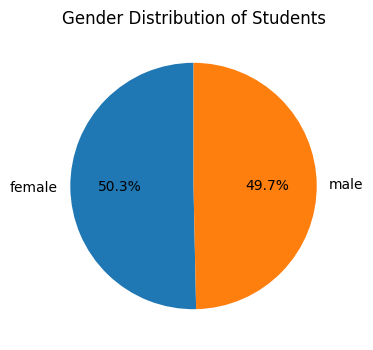

In [17]:
# Calculate geneder percentage and plot it.
gender_counts = exam_score['gender'].value_counts()

# Calculate the percentage of students in each gender category
gender_percentages = (gender_counts / len(exam_score)) * 100

gender_counts
gender_percentages

# Plot the gender using pie chart.
plt.figure(figsize=(4, 4))
plt.pie(gender_percentages, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Gender Distribution of Students')
plt.show()

##### The geneder distribution is almost equal for Femal and Male students.

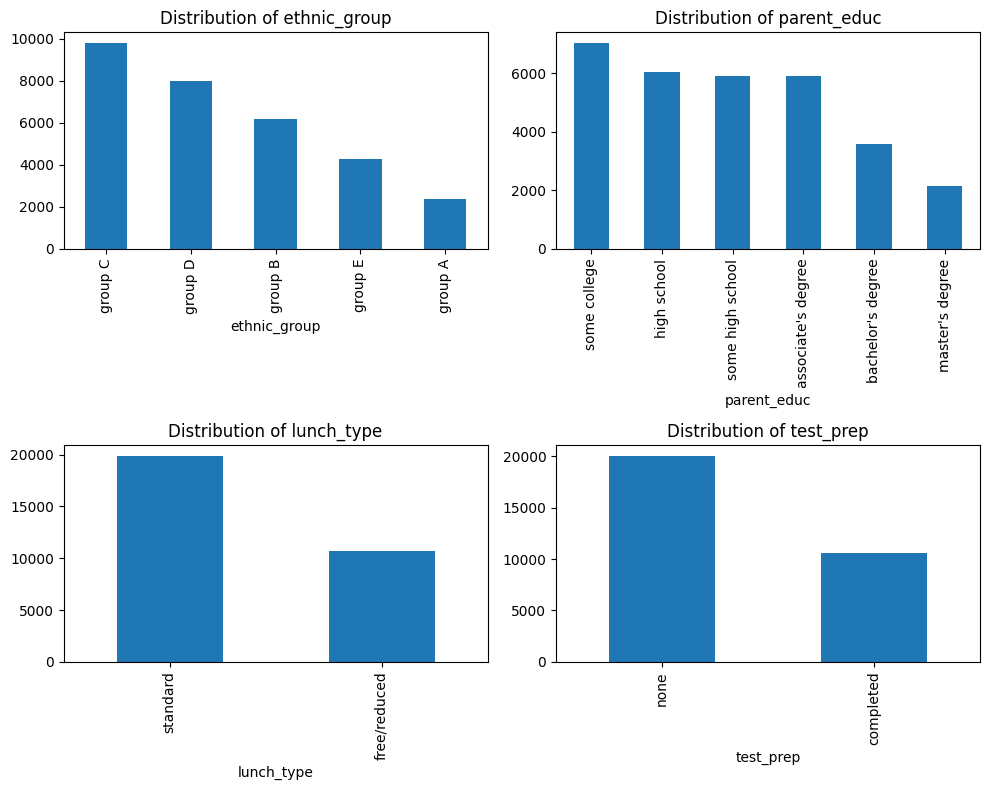

In [18]:
# Create a figure and four subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Iterate over the columns and create the distribution plots
columns = ['ethnic_group', 'parent_educ', 'lunch_type', 'test_prep']
for i, col in enumerate(columns):
    ax = axs[i//2, i%2]
    exam_score[col].value_counts().plot(kind='bar', ax=ax)
    ax.set_title(f"Distribution of {col}")

# Adjust the spacing between subplots
plt.tight_layout()

# Display the merged graph
plt.show()

##### - Ethnic Group
        - Group-C has the heighest and Group-A has the lowest students
##### - Parent Education Background
        - Most students have parents who have some collage eduactional background and the least for master's degree.
##### - Lunch Type
        - More number of students use standard lunch type.
##### - Test Preparation
        - Most number of students have no test preparation.

##### Visualizing the distribution of the score

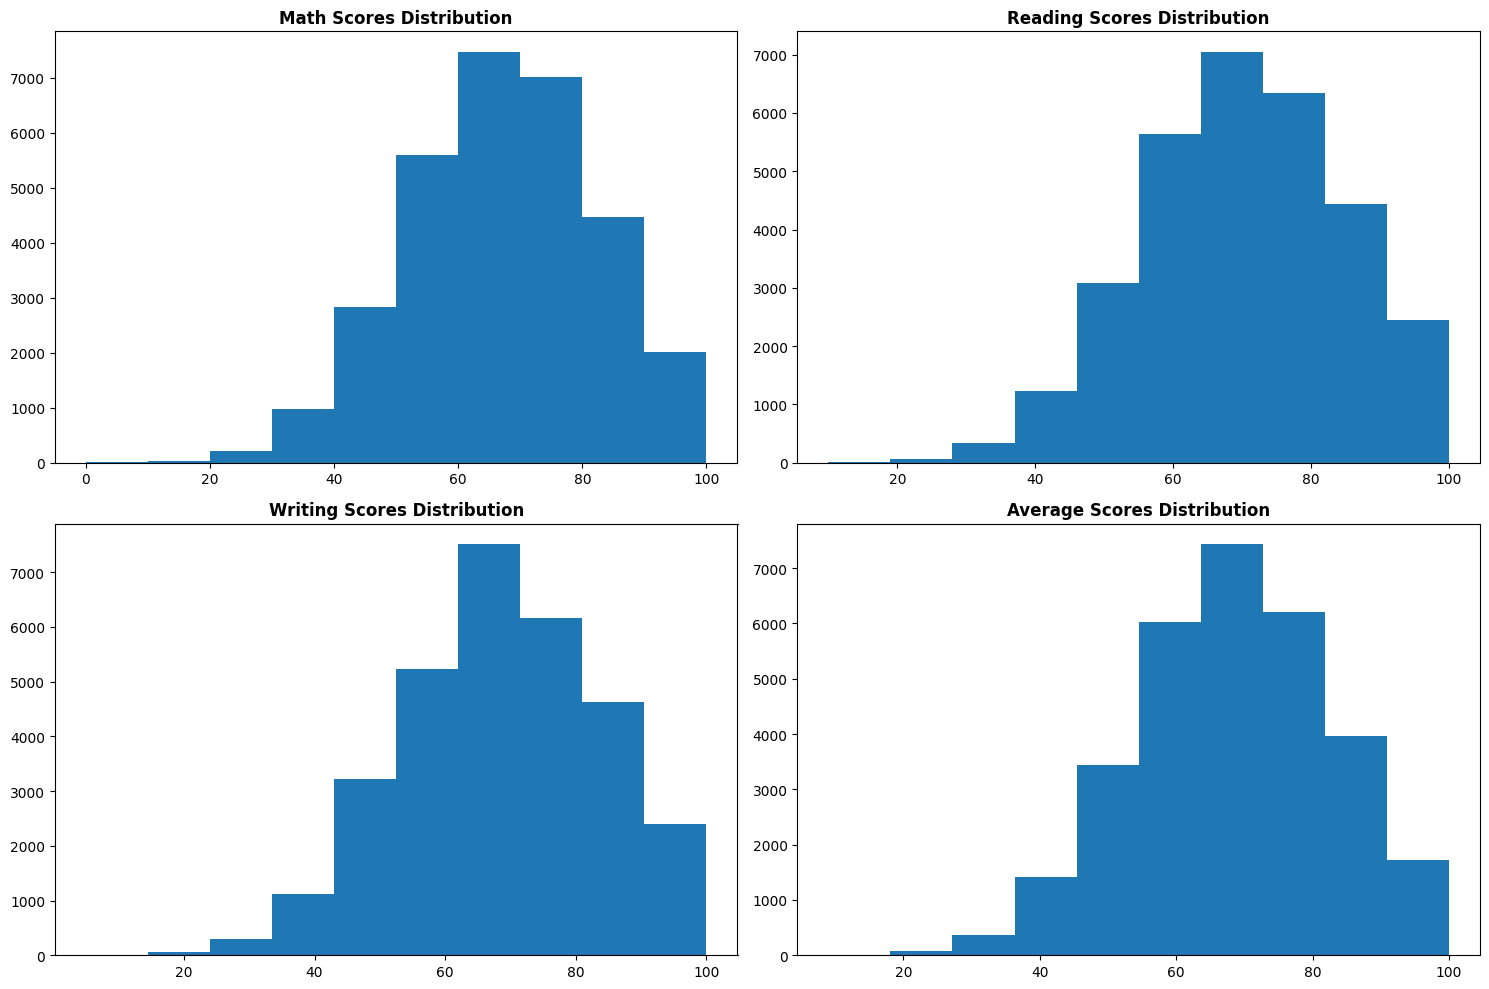

In [19]:
# Create 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Histogram for Math-score
axs[0, 0].hist(exam_score['math_score'])
axs[0, 0].set_title('Math Scores Distribution', fontweight='bold')

# Histogram for Reading-score
axs[0, 1].hist(exam_score['reading_score'])
axs[0, 1].set_title('Reading Scores Distribution',fontweight='bold')

# Histogram for Writing-score
axs[1, 0].hist(exam_score['writing_score'])
axs[1, 0].set_title('Writing Scores Distribution',fontweight='bold')

# Histogram for Average-score
axs[1, 1].hist(exam_score['average_score'])
axs[1, 1].set_title('Average Scores Distribution',fontweight='bold')

# Adjust the spacing between subplots
fig.tight_layout()
plt.show()

#### From the graph, we can notic that

##### -	Math Scores:
	The distribution appears to be approximately symmetrical, with observations distributed similarly on both sides of the peak. Therefore, it has approximately zero skew.
	The mean and median are almost equal, which further supports the lack of significant skewness.
##### -	Reading Scores:
	The distribution is slightly right-skewed, indicating that some students achieved higher reading scores, but the majority fall within the middle range.
##### -	Writing Scores:
	Similar to the reading scores, this distribution is also right-skewed. The tail extends to the right, suggesting that some students achieved higher writing scores, but they are relatively rare compared to lower scores.
##### -	Average Scores:
	The average scores distribution combines the three subject scores. Overall, most students have average scores in this range.
    
Generally, we can say that all four scores appear to exhibit a normal distribution, but we observe some deviation towards lower scores from the mean. This deviation could potentially lead to outliers.

#### Visualize the outliers

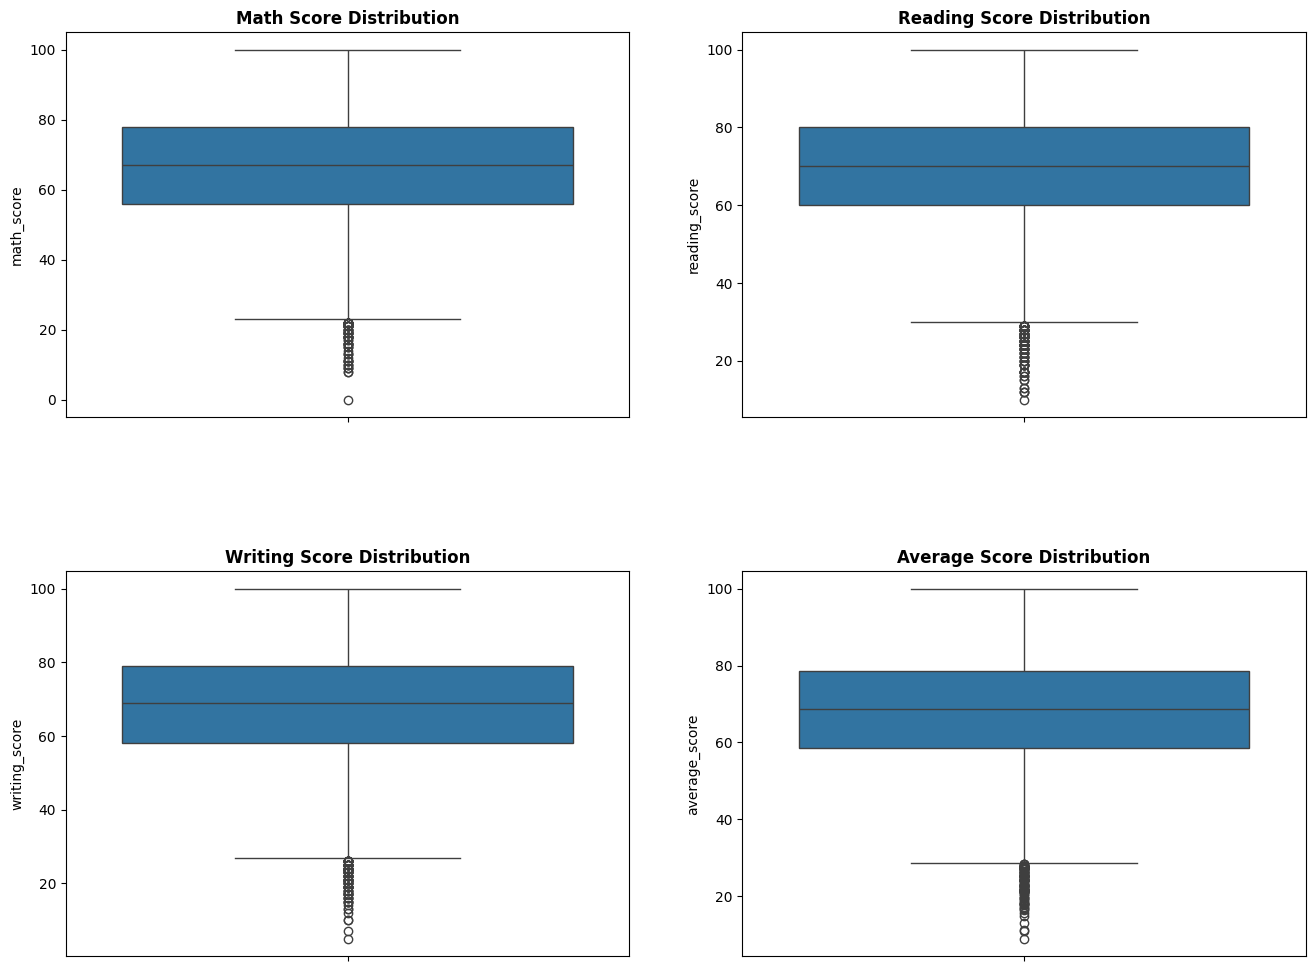

In [20]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.4)

# Create box plots for Math Score, Reading Score, Writing Score, and Average Score
sns.boxplot(ax=axes[0, 0], data=exam_score, y='math_score')
axes[0, 0].set_title('Math Score Distribution',fontweight='bold')
sns.boxplot(ax=axes[0, 1], data=exam_score, y='reading_score')
axes[0, 1].set_title('Reading Score Distribution',fontweight='bold')
sns.boxplot(ax=axes[1, 0], data=exam_score, y='writing_score')
axes[1, 0].set_title('Writing Score Distribution',fontweight='bold')
sns.boxplot(ax=axes[1, 1], data=exam_score, y='average_score')
axes[1, 1].set_title('Average Score Distribution',fontweight='bold')

# Display the plot
plt.show()

Based on the box plots above for the four scores, the students with the lowest scores are considered outliers, meaning they deviate significantly from the majority of students in comparison to their score.

#### BI-Variate Analysis

##### - Analyze exam scores based on gender

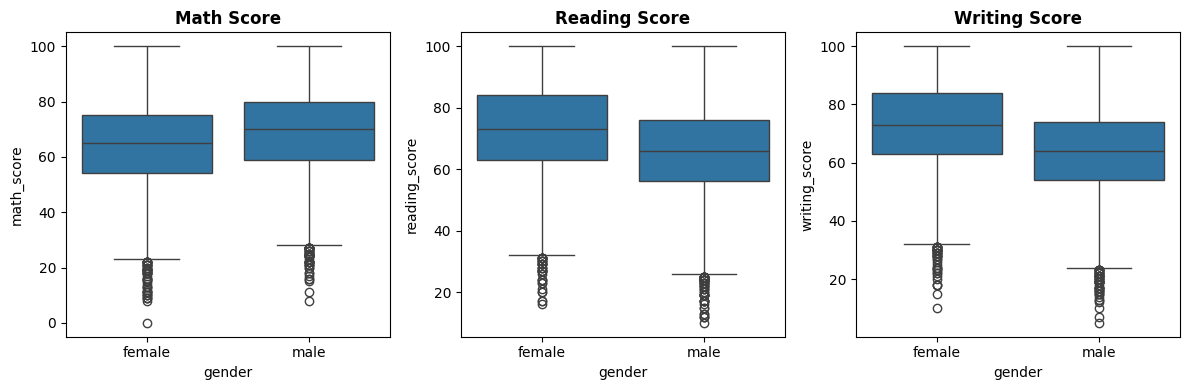

In [21]:
# Create a figure and three subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Box plot of MathScore by Gender
sns.boxplot(ax=axs[0], x='gender', y='math_score', data=exam_score)
axs[0].set_title('Math Score',fontweight='bold')

# Box plot of ReadingScore by Gender
sns.boxplot(ax=axs[1], x='gender', y='reading_score', data=exam_score)
axs[1].set_title('Reading Score',fontweight='bold')

# Box plot of WritingScore by Gender
sns.boxplot(ax=axs[2], x='gender', y='writing_score', data=exam_score)
axs[2].set_title('Writing Score',fontweight='bold')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the merged plot
plt.show()

- Female students have more score in reading and writing.
- The lowest score in math scored by female.

##### - Analyze exam scores based on ethnic group

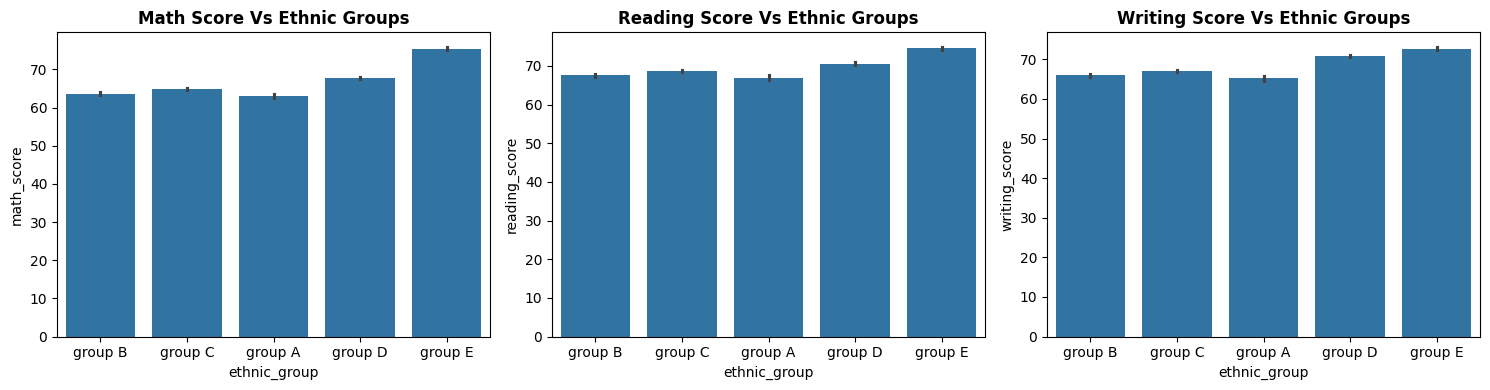

In [22]:
# Create a figure and three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# Bar plot of Math Score with respect to Ethnic Groups
sns.barplot(ax=axs[0], x='ethnic_group', y='math_score', data=exam_score)
axs[0].set_title('Math Score Vs Ethnic Groups', fontweight='bold')

# Bar plot of Reading Score with respect to Ethnic Groups
sns.barplot(ax=axs[1], x='ethnic_group', y='reading_score', data=exam_score)
axs[1].set_title('Reading Score Vs Ethnic Groups',fontweight='bold')

# Bar plot of Math Score with respect to Ethnic Groups
sns.barplot(ax=axs[2], x='ethnic_group', y='writing_score', data=exam_score)
axs[2].set_title('Writing Score Vs Ethnic Groups',fontweight='bold')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

- Ethnic Group E has the heighst score in the three exam scores. On the other hand, Ethnic Group A has the lowest.


##### - Analyze exam scores based on parents educational background

<ipython-input-23-737095cb520d>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, horizontalalignment='right')
<ipython-input-23-737095cb520d>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, horizontalalignment='right')
<ipython-input-23-737095cb520d>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=45, horizontalalignment='right')


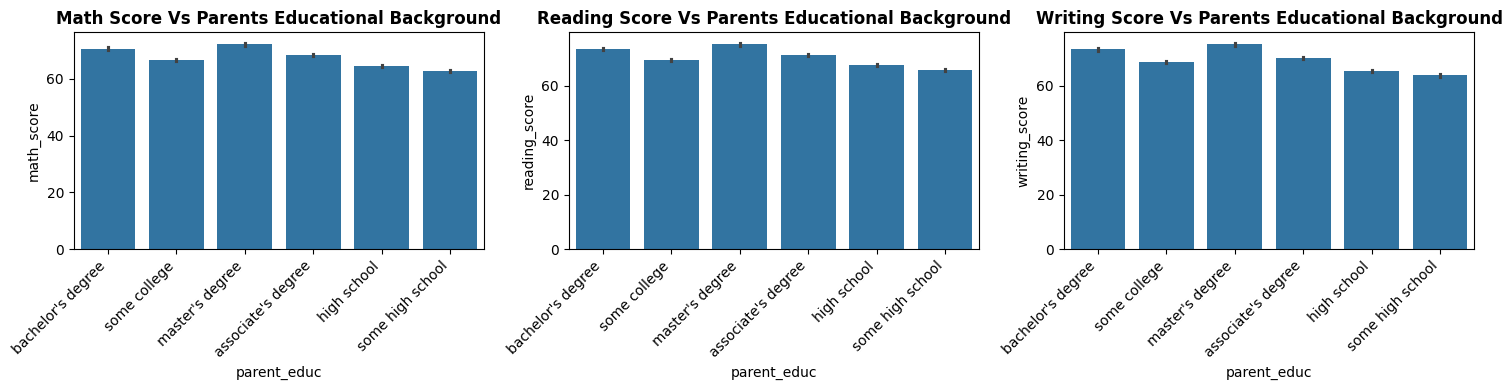

In [23]:
# Create a figure and three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# Bar plot of Math Score with respect to Parents Educational Background
sns.barplot(ax=axs[0], x='parent_educ', y='math_score', data=exam_score)
axs[0].set_title('Math Score Vs Parents Educational Background',fontweight='bold')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, horizontalalignment='right')

# Bar plot of Reading Score with respect to  Parents Educational Background
sns.barplot(ax=axs[1], x='parent_educ', y='reading_score', data=exam_score)
axs[1].set_title('Reading Score Vs Parents Educational Background',fontweight='bold')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, horizontalalignment='right')

# Bar plot of Math Score with respect to  Parents Educational Background
sns.barplot(ax=axs[2], x='parent_educ', y='writing_score', data=exam_score)
axs[2].set_title('Writing Score Vs Parents Educational Background',fontweight='bold')
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=45, horizontalalignment='right')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

- Parental education appears to correlate with student achievement on every exam. A student whose parents hold master's and bachelor's degrees is more likely to achieve high scores on all examinations.

- Student performance is lowest among those whose parents have only completed high school.

##### - Analyze exam scores based on test preparation

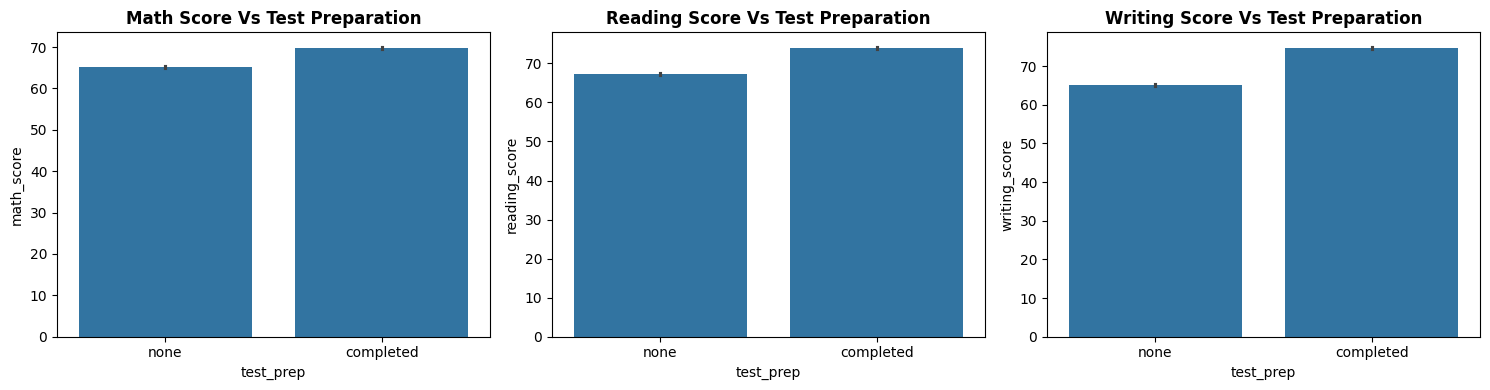

In [24]:
# Create a figure and three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# Bar plot of Math Score with respect to Test Preparation
sns.barplot(ax=axs[0], x='test_prep', y='math_score', data=exam_score)
axs[0].set_title('Math Score Vs Test Preparation', fontweight='bold')

# Bar plot of Reading Score with respect to Test Preparation
sns.barplot(ax=axs[1], x='test_prep', y='reading_score', data=exam_score)
axs[1].set_title('Reading Score Vs Test Preparation',fontweight='bold')

# Bar plot of Math Score with respect to Test Preparation
sns.barplot(ax=axs[2], x='test_prep', y='writing_score', data=exam_score)
axs[2].set_title('Writing Score Vs Test Preparation',fontweight='bold')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

- It is clearly seen that students that complete the test preparation score higher than those with none.

##### - Analyze exam scores based on lunch type

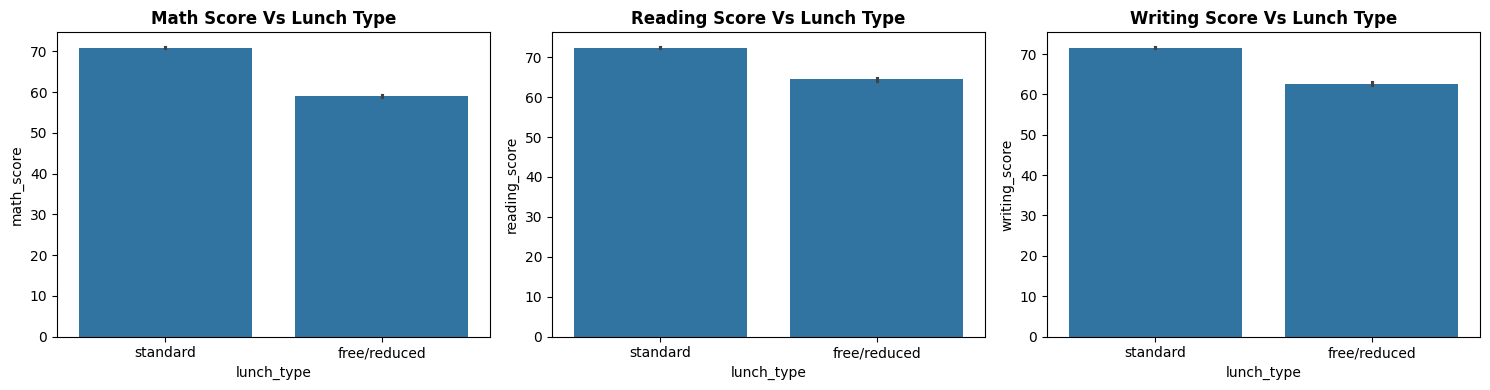

In [25]:
# Create a figure and three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# Bar plot of Math Score with respect to Lunch Type
sns.barplot(ax=axs[0], x='lunch_type', y='math_score', data=exam_score)
axs[0].set_title('Math Score Vs Lunch Type', fontweight='bold')

# Bar plot of Reading Score with respect to Lunch Type
sns.barplot(ax=axs[1], x='lunch_type', y='reading_score', data=exam_score)
axs[1].set_title('Reading Score Vs Lunch Type',fontweight='bold')

# Bar plot of Math Score with respect to Lunch Type
sns.barplot(ax=axs[2], x='lunch_type', y='writing_score', data=exam_score)
axs[2].set_title('Writing Score Vs Lunch Type',fontweight='bold')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

- For all exam scores heigher scores are from students with standard lunch type.

#### Visualize the rlation between the three scores

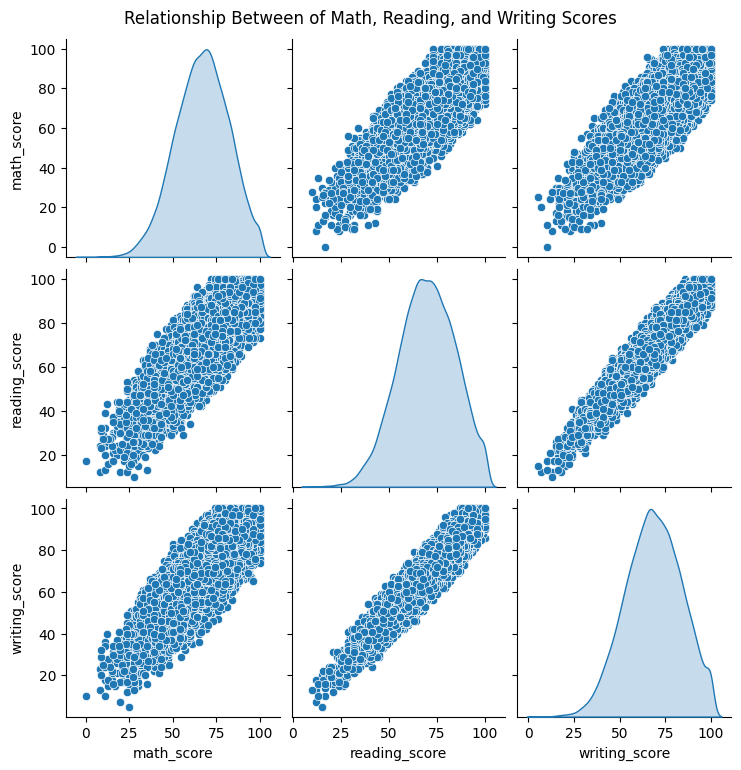

In [26]:
import warnings
warnings.filterwarnings('ignore')

# Select the variables you want to include in the scatterplot matrix
selected_vars = exam_score[['math_score', 'reading_score', 'writing_score']]

# Create a scatterplot matrix
sns.pairplot(selected_vars, diag_kind='kde')
plt.suptitle('Relationship Between of Math, Reading, and Writing Scores', y=1.02)
plt.show()

- It can be seen from the preceding plots that there is a positive direct relationship between each exam score; therefore, students who achieve high scores in mathematics are more likely to do well in reading and writing as well, and conversely.

#### Visualize the Corrlation between sores and the other features

- To visualize the correlation of scores with respect to given features, the data type should be numeric. Therefore, we should change the categorical data type to numeric using OneHot Encoder.

In [27]:
# Identify the categorical data types
catogrical_column = [column for column in exam_score.columns if
exam_score[column].
dtypes=='object']
print(catogrical_column)

['gender', 'ethnic_group', 'parent_educ', 'lunch_type', 'test_prep']


In [28]:
# Define the function for one-hot encoding
def perform_one_hot_encoding(exam_score, column_name):
    # Perform one-hot encoding on the specified column
    dummies = pd.get_dummies(exam_score[column_name], prefix=column_name, dtype=int)

    # Drop the original column and append the new dummy columns to the dataframe
    exam_score = pd.concat([ exam_score.drop(column_name, axis=1), dummies], axis=1)

    return  exam_score

data =  exam_score.copy()
data1 =  exam_score.copy()

# Perform one-hot encoding on the categorical variables
for column in ['gender', 'ethnic_group', 'parent_educ', 'lunch_type', 'test_prep']:
    data = perform_one_hot_encoding(data, column)

# Perform one-hot encoding on the categorical variables
for column in ['gender', 'ethnic_group', 'parent_educ', 'lunch_type', 'test_prep']:
    data1 = perform_one_hot_encoding(data1, column)

##### Now let's visualize the correlation

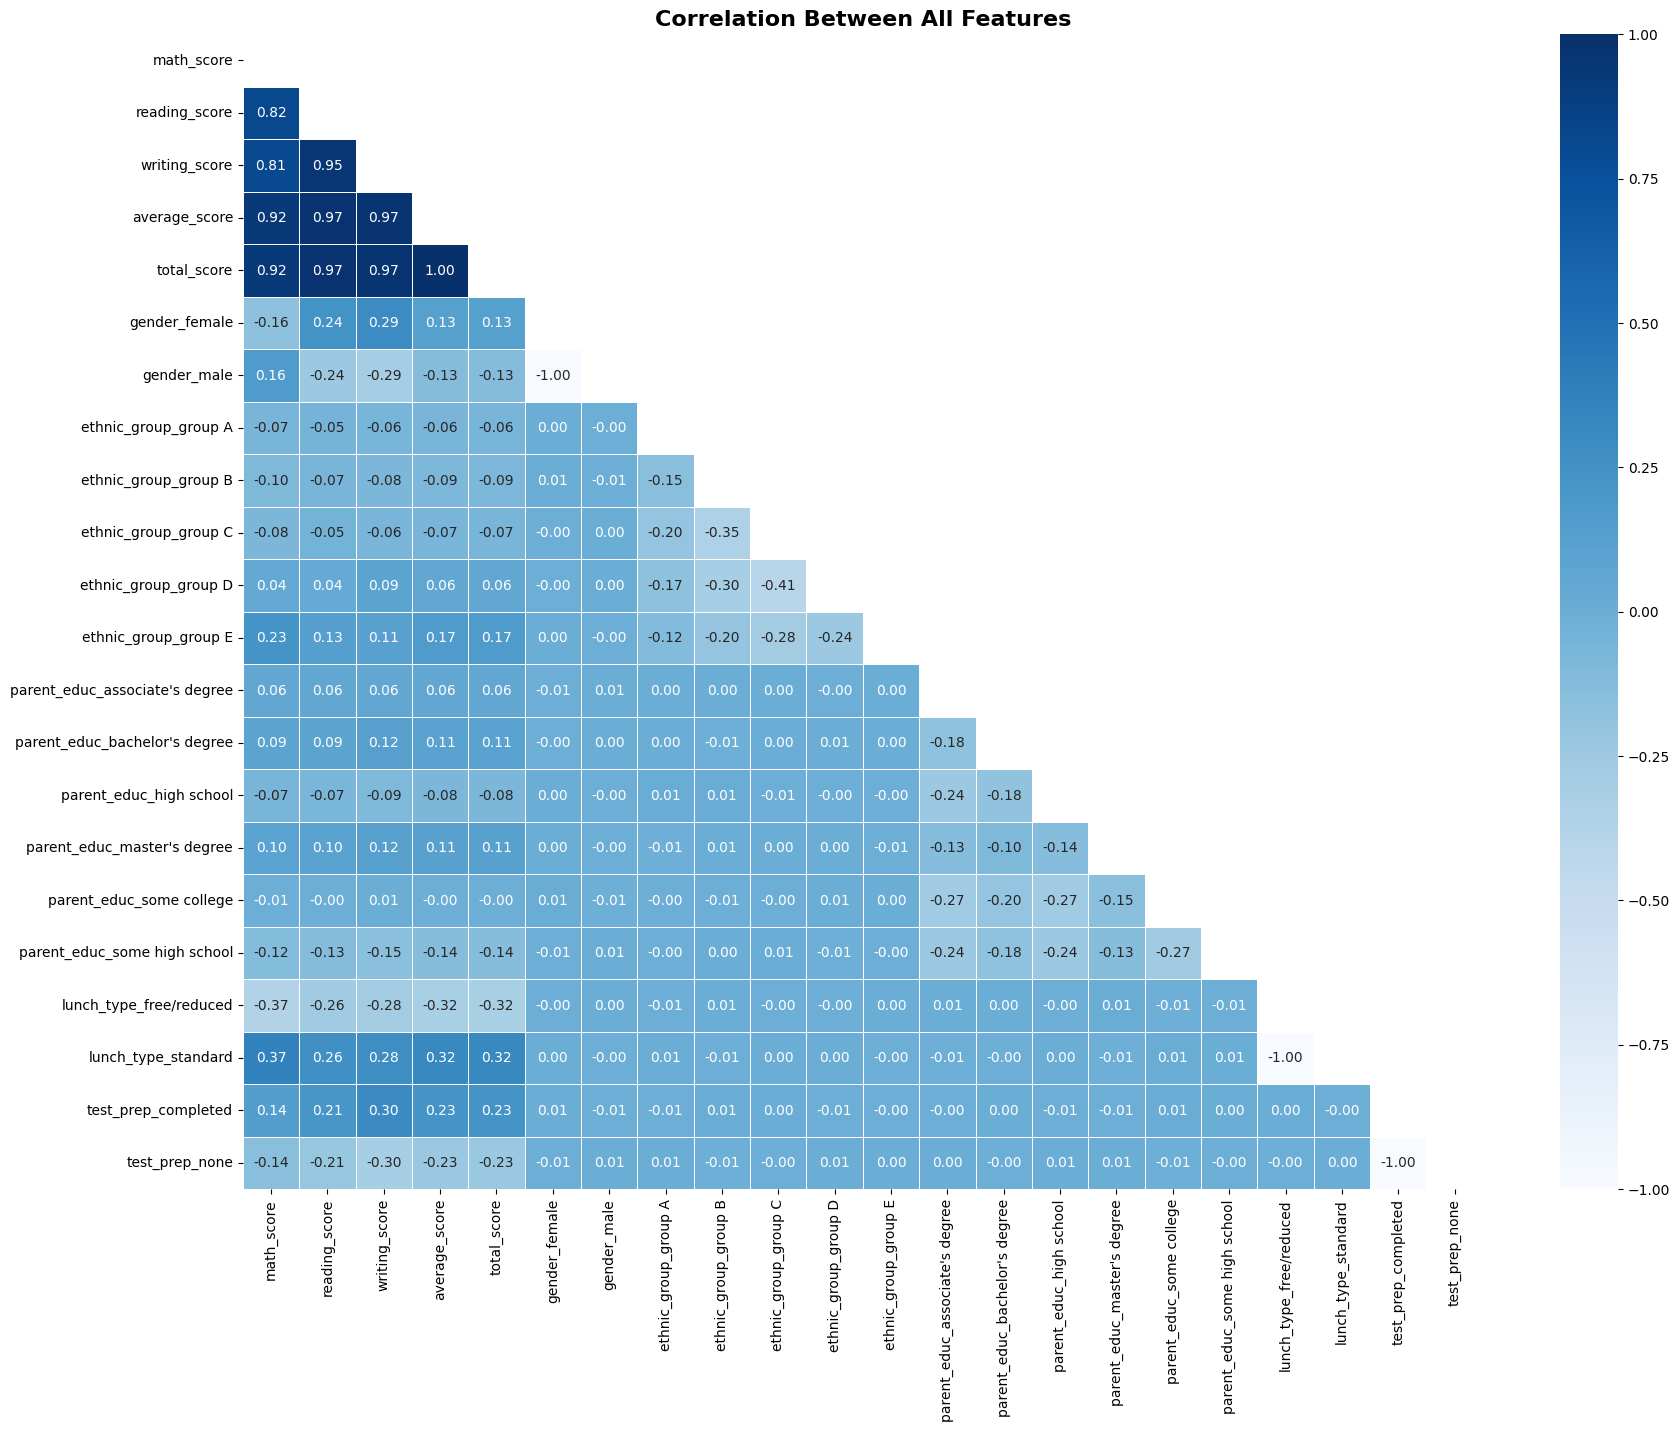

In [29]:

# Calculate the correlation matrix
correlation_matrix = data1.corr()

# Create a mask for the upper triangle
mask = np.triu(correlation_matrix)

# Plot the heatmap with the lower triangle
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', linewidths=0.5, fmt='.2f', mask=mask)
plt.title("Correlation Between All Features", fontweight='bold', fontsize=16)
plt.show()

- As the target values are the three exam scores, let us visualize each score individually the correlation with respect to the features.

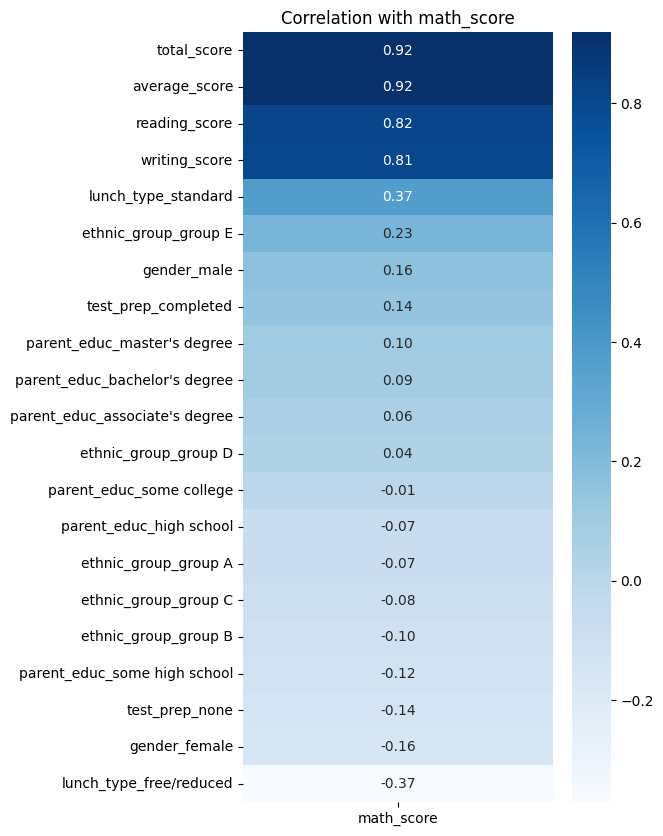

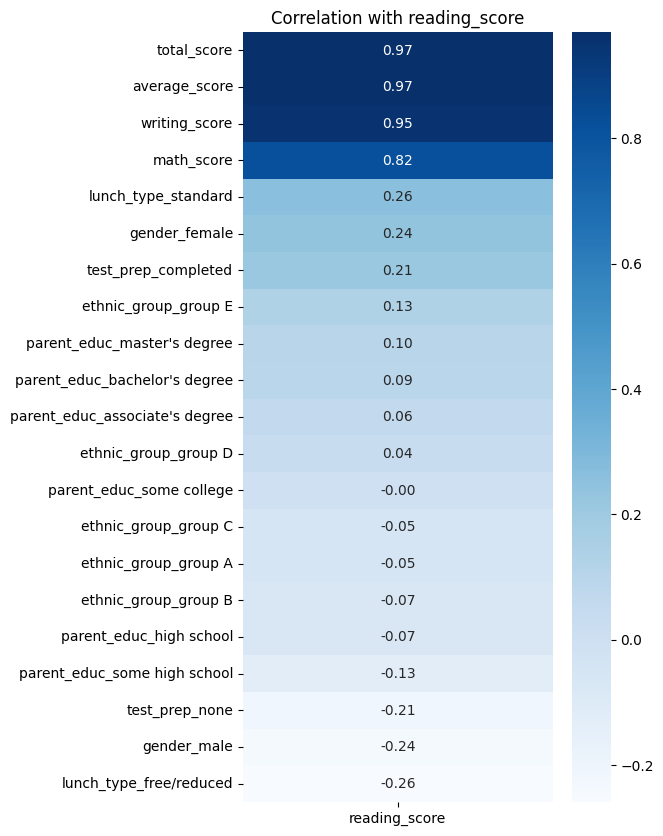

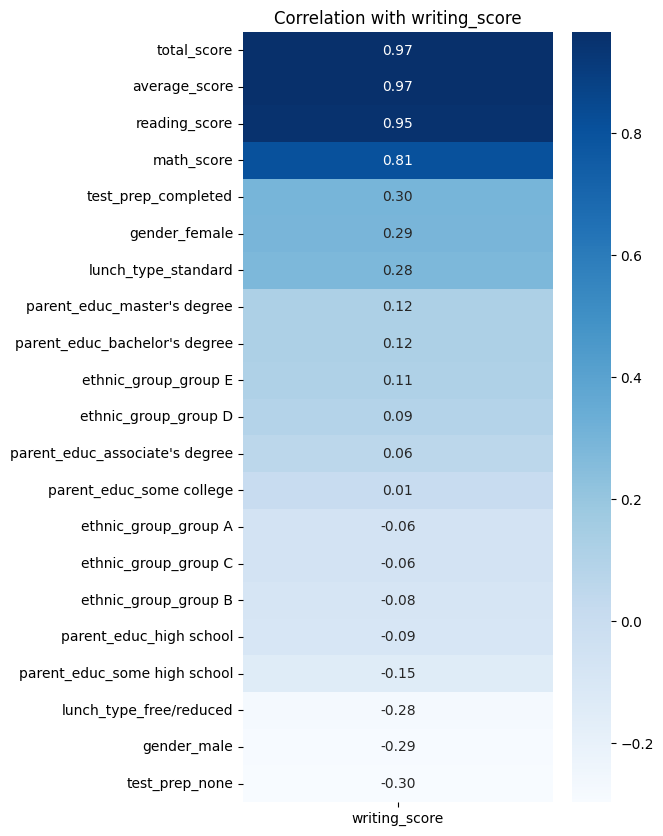

In [30]:
# Correlation with MathScore, ReadingScore, WritingScore
for score_column in ['math_score', 'reading_score', 'writing_score']:

    # Create a heatmap of the correlations with the target column
    corr = data.corr()
    target_corr = corr[score_column].drop(score_column)

    # Sort correlation values in descending order
    target_corr_sorted = target_corr.sort_values(ascending=False)

    plt.figure(figsize=(5, 10))
    sns.heatmap(target_corr_sorted.to_frame(), cmap="Blues", annot=True, fmt='.2f')
    plt.title(f'Correlation with {score_column}')
    plt.show()

### General Insights from the analysis: -

- It can be seen that test preparation completed has a posetive relation to the whole exam scores. This means that test preparation can enhance a student's understanding of the subject and improve test-taking skills, to lead a better exam performance.

- Considering the Ethnic group Group E and D have a positive correlation to exam scores but other groups, i.e A, B and C, have a negative correlation. Specially, group E has higher positive correlation in math score which further indicate this groups have the probability of higher score.

- Writing and reading scores are dominated by female students and math score with male.

- Each of the three scores correlates significantly with the LunchType; students who consume a standard lunch generally achieve higher scores. Socioeconomic status might be approximated by this metric.

- In terms of academic achievement, children whose parents hold a Master's degree tend to perform better academically. The scores of students whose parents have only completed high school are, on average, lower. This may serve as an additional indicator of socioeconomic status, or it may indicate that parents with a higher level of education are more capable of providing financial support for their children's education.

